<h2><center>NYC green taxi data analysis</center></h2>
<h4><center>Husen Zhang</center></h4>

#### README
The goal is to explore how New Yorkers use the 'Green Taxi'. The entire analysis is contained in this jupyter notebook. Library versions are printed early on. To produce html from the command line: jupyter nbconvert --execute --ExecutePreprocessor.timeout=150 nycTaxi_HusenZhang.ipynb

In [1]:
import sys
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Download the data and explore rows and columns.

In [3]:
url='https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
df = pd.read_csv(urlopen(url))

In [5]:
print('n_rows = %d, n_columns = %d' %(df.shape))
df.head(2)

n_rows = 1494926, n_columns = 21


,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0


Trip distance median (indicated by the red line) is 2 miles. Skewed distribution towards short trips.

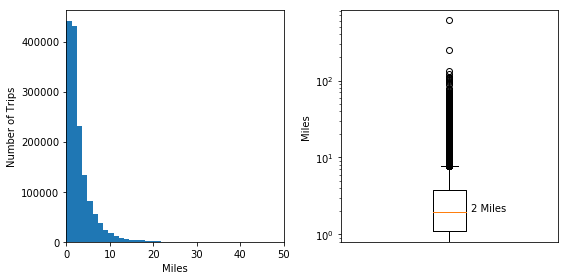

In [15]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(df['Trip_distance'].values, bins=500)
ax1.set_ylabel('Number of Trips')
ax1.set_xlabel('Miles')
ax1.set_xlim([0,50])

ax2.boxplot(df['Trip_distance'].values)
ax2.set_yscale('log')
ax2.set_ylabel('Miles')
ax2.get_xaxis().set_ticks([])
ax2.annotate('2 Miles', xy=(1,2), xytext=(1.1, 2))

fig.tight_layout()

We know the pickup_hour and dropoff_hour of each trip.  In order to get hour of day of these trips, we need to deal with the dateime type. Once that's done, we generate a pivot table.  The peak distance seems to be at 5am, where Wall-street folks get to work.Trips to airports is coded in the field, RateIDCode. Please see below for more details.I also generate a figure using the same data. One hypothesis for the peak distance early morning and late evening: Wall Street folks get to work around 5am, get home around 10pm. If I had more time, I would investigate the dropoff locations at 5-6am with a distance of 4 miles and above to see whether my hypothesis is true.  I will need to something like geocoding to do this kind of analysis.

In [16]:
df['Pickup_hour'] = df.set_index(
        pd.to_datetime(df.lpep_pickup_datetime)).index.hour
df['Dropoff_hour'] = df.set_index(
        pd.to_datetime(df.Lpep_dropoff_datetime)).index.hour

Table1 = df.pivot_table(index='Pickup_hour', 
                        values='Trip_distance',
                        aggfunc='mean').round(2)
#print 'Table1. Trip_distance By Pickup_hour\n','-'*36+'\n', Table1

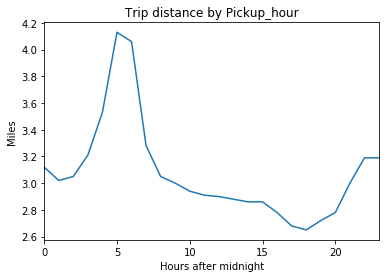

In [17]:
def plot_pickup():
    p = Table1.plot()
    p.set_ylabel('Miles')
    p.set_xlabel('Hours after midnight')
    p.set_title('Trip distance by Pickup_hour')
plot_pickup()

RateIDCode for JFK and Newark airports are 2 and 3, respectively. We see trips to Newark charges more, despite lower fare.  This disparity could be due to tolls at the George Washington Bridge. 

        RateCode  Trips  average Fare  average Total
JFK            2   4435         49.02          56.53
Newark         3   1117         48.80          59.90


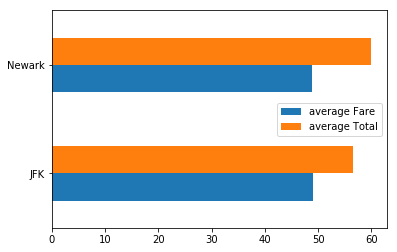

In [28]:
def twoAirports():
    jfk    = df[df.RateCodeID == 2].shape[0]
    newark = df[df.RateCodeID == 3].shape[0]
    avgf   = df.Fare_amount.groupby([df.RateCodeID]).mean()
    avgt   = df.Total_amount.groupby([df.RateCodeID]).mean()
    airports = pd.DataFrame({'Trips': (jfk, newark), 
                        'average Fare': np.round((avgf[2], avgf[3]),2),
                       'average Total': np.round((avgt[2], avgt[3]),2), 
                       'RateCode':(2, 3)}, 
                        index=['JFK', 'Newark'])
    print (airports)
    airports[['average Fare', 'average Total']].plot.barh()
twoAirports()

Build a predictive model for tip as a percentage of the total fare.
Cash tips are not recorded 
  - using only credit card transactions. 
Creating a data cleaning helper function, preproc.
  - drop datetime columns but keep Pickup_hour/Dropoff_hour
  - drop the Ehail_fee column which contains only NAs.
Then I follow the good practice of model building, namely, training the model on the train set followed by testing it on the test set.

In [29]:
def preproc(data):
    """Return a copy of clean data with Tip_percent."""
    data = data[data.Payment_type == 1] # credit card only.
    data = data.drop(
           ['Payment_type','lpep_pickup_datetime','Dropoff_latitude',
            'Lpep_dropoff_datetime', 'Ehail_fee','Pickup_latitude',
            'Pickup_longitude','Dropoff_longitude'], axis=1)
    
    # Deal with NAs and strings; float to integers
    data.fillna(method = 'ffill', inplace=True)
    data.Store_and_fwd_flag = (
               data.Store_and_fwd_flag == 'Y').astype(int)
    data['Trip_type '] = data['Trip_type '].astype('int')
            
    # flip negative values caused by data entry errors.    
    fields=['Fare_amount','Extra','MTA_tax','Tip_amount','Total_amount']
    for field in fields:
        data[field] = data[field].abs()
    
    data['Tip_percent'] = data.Tip_amount/data.Total_amount
    data.Tip_percent = data.Tip_percent.fillna(data.Tip_percent.mean())
    data.drop('Tip_amount', axis=1, inplace=True)
    return data

data = preproc(df)

In [33]:
data.shape[1]

15

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f84bbe0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1209a19b0>]], dtype=object)

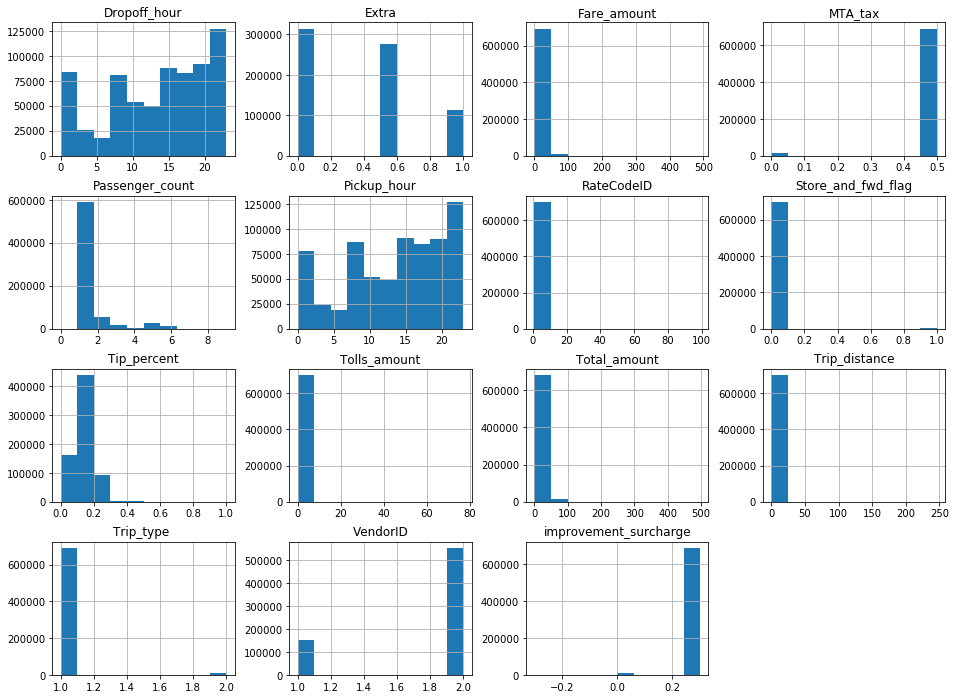

In [36]:
data.hist(figsize=(16,12))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Mean absolute error: 0.000497996895789 	R2: 0.9958


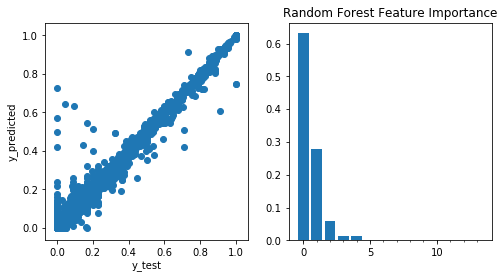

In [49]:
def rfm():    
    target = 'Tip_percent'
    features = [i for i in data.columns if i != target]
    X_train, X_test, y_train, y_test = train_test_split(
             data[features], data[target], test_size=0.3, random_state=0 )

    rf = RandomForestRegressor(n_estimators=10, n_jobs=2)
    rf.fit(X_train, y_train)
    print (rf)

    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    rsqr = format(r2_score(y_test, y_pred), '0.4f')
    print ('Mean absolute error:', mae,'\tR2:',rsqr)

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    ax1.scatter(y_test, y_pred)
    ax1.set_xlabel('y_test')
    ax1.set_ylabel('y_predicted')
    importance_data = sorted(zip(X_test.columns, rf.feature_importances_),
                         key=lambda x: x[1], reverse=True)
    xlab, ylab = zip(*importance_data)
    xloc = range(len(X_test.columns))
    ax2.bar(xloc, ylab)
    ax2.set_xticks(xloc, xlab)
    ax2.set_title('Random Forest Feature Importance')

rfm()

Now test the model with the test data. I assess accuracies with the mean absolute error (MAE).  The MAE is intuitive - a value of 0.01 corresponds to 1 percent difference. I also report r-square, which indicates how much variation is explained by the model.

### Question 5
Option A: Distributions
Build a derived variable representing the average speed over the course of a trip.
Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?
Can you build up a hypothesis of average trip speed as a function of time of day?
### Answers:
First let's create a helpfer function, get_speed_week, to compute average speed. As a byproduct we also get the week information. Then I proceed to do two exploratory plots: average speed versus week, and average speed versus pickup_hour. 

The average speed does not seem to vary a whole lot from week-to-week. In contrast, the average speed is highest at 5-6am in the morning, suggesting least amount of traffice congestion.

In [15]:
def get_speed_week(dat):
    end = pd.to_datetime(dat.Lpep_dropoff_datetime)
    begin = pd.to_datetime(dat.lpep_pickup_datetime)
    duration = (end - begin).astype('timedelta64[s]')
    speed = (dat.Trip_distance/duration)*3600
    week = dat.set_index(pd.to_datetime(
            dat.lpep_pickup_datetime)).index.week
    return speed, week

In [ ]:
df['Speed'], df['Week'] = get_speed_week(df)

Further cleanup to remove inf and nan:

In [16]:
df1 = df[['Speed', 'Week', 'Pickup_hour']].replace(
    [np.inf, -np.inf], np.nan)

df1.dropna(inplace=True)

Now let's do a boxplot with Speed versus Week. No obvious trend is observed.

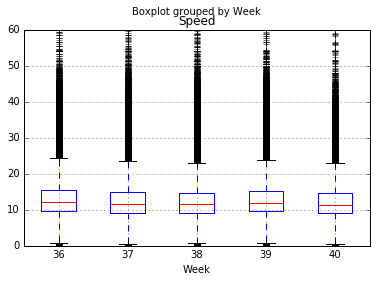

In [46]:
df1[df1.Speed < 60].boxplot('Speed', by='Week')

In the interest of time, I'll treat 'Week' as a categorical variable and do a simple linear regression of Speed ~ Week. The p-value is 0.0626, which is greater than 0.05.  We can't reject the null hypothesis, which states no difference in speed between weeks. 

In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [50]:
df1.Week = df1.Week.astype('category')
mod = ols('Speed ~ Week', data=df1).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

                sum_sq         df         F    PR(>F)
Week      4.166030e+05        4.0  2.234507  0.062668
Residual  6.962817e+10  1493841.0       NaN       NaN


Now take a look at speed versus hour-of-the-day.

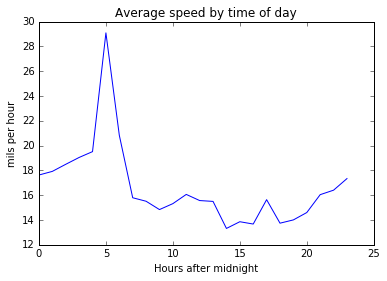

In [25]:
plt.plot( df1.pivot_table('Speed', 'Pickup_hour'))
plt.title('Average speed by time of day')
plt.xlabel('Hours after midnight')
plt.ylabel('mils per hour')

Obviously the average speed is highest at 5-6am in the morning! Again, in the interest of time let's treat the Pickup_hour as a categorical variable and perform linear regression:

In [51]:
df1.Pickup_hour = df1.Pickup_hour.astype('category')
mod = ols('Speed ~ Pickup_hour', data=df1).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

                   sum_sq         df         F        PR(>F)
Pickup_hour  7.191228e+06       23.0  6.708592  1.995128e-21
Residual     6.962140e+10  1493822.0       NaN           NaN


Now the p-value is extremely small (1.99e-21), suggesting that the average speed does vary according to the time of the day with 5-6am being the highest speed. The highest speed at 5am suggests a relatively smooth traffic in the early morning.  So, if you do need to travel, travel early in the morning.

##### This concludes the entire analysis.